In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

import torch, config
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('seaborn')

/home/abian/Workspace/Anaconda/envs/ResearchStay/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# An Informatic-Theoretical view on CLHU

$\begin{align}
\mathcal{I}(X; Z) + \lambda \mathcal{R}(Z)
\end{align}$

## Jasper Ridge dataset

In [2]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)

From the dataset, separate a test subset, picking up the 32 samples with the highest 'abundance' value per endmember. Im total, the test subset is going to contain 128 samples.

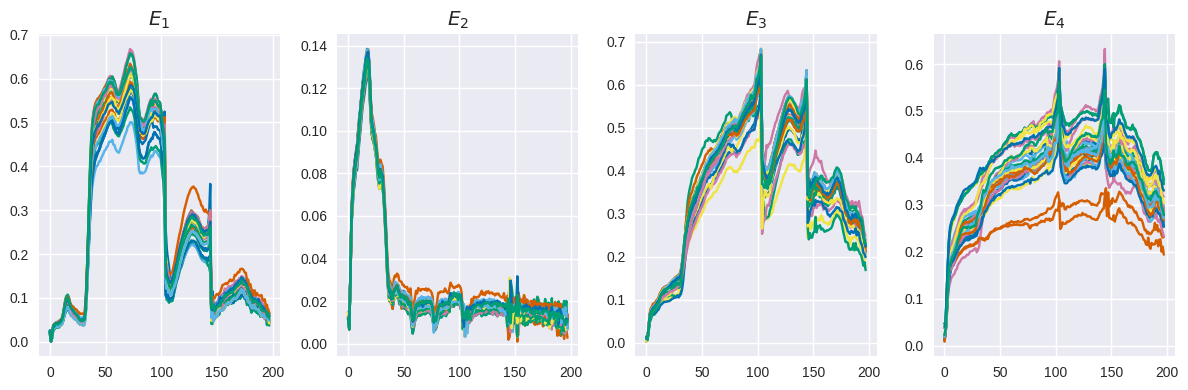

In [3]:
gt = dataset.abundance().permute(2,0,1)

#pick up the 32 first samples with the highest abundance per endmember
test_idx = torch.zeros(dataset.n_endmembers, 32, dtype=torch.long)
for i in range(dataset.n_endmembers):
    _, test_idx[i,:] = torch.topk(gt[i,:,:].flatten(), 32)

# sepparate train samples and test samples
train_idx = torch.ones_like(gt[0,:,:].flatten(), dtype=torch.bool)
train_idx[test_idx] = False
train_idx = torch.where(train_idx)[0]

# plot it
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(dataset[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

In [4]:
# create a subset of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx.flatten())

## CLHU Model
The CLHU model including the IPDL modules for IP estimation.

In [5]:
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from HySpecLab.unmixing.mixture import lmm
from HySpecLab.unmixing.utils import slide

from IPDL import MatrixEstimator

import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(encode_layers[-1], n_bands, bias=False),
            MatrixEstimator(.1)
        )
        
        # Abundance matrix
        self.A = None
        self.A_matrix_estimator = MatrixEstimator(.1)
        self.matrix_estimator = MatrixEstimator(.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.A_matrix_estimator(self.__similarity(r0))
        out = lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))
        return self.matrix_estimator(out)
        # return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            MatrixEstimator(.1),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        return (1 - torch.pow(cos, 2))/temperature

In [44]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPDL import AutoEncoderInformationPlane
from IPDL.optim import SilvermanOptimizer

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

# from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, train_dataset:Dataset, test_dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(train_dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')


    dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 0
    simplex_weight = 1e-5
    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    #IPDL
    matrix_optimizer = SilvermanOptimizer(model, gamma=1e-2, normalize_dim=True)
    ip = AutoEncoderInformationPlane(model)
    Ax = define_Ax(test_dataset[:], gamma=1e-2)

    with torch.no_grad():
        model.eval()
        x = test_dataset[:].to(device)
        y = model(x)

    for epoch in epoch_iterator:
        epoch_loss = 0.
        model.train()
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            model.eval()
            x = test_dataset[:].to(device)
            y = model(x)
            test_loss = criterion(y, x)
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)), vls="%.4f" % test_loss.item())

        if epoch == 0: # Solo necesario una vez
            matrix_optimizer.step()

        _, _ = ip.computeMutualInformation(Ax.to(device))

    return ip

## Endmember estimation for initialization

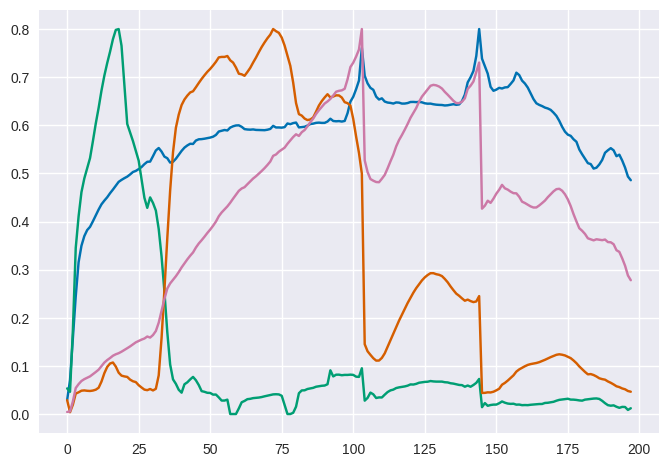

In [63]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers + 0
vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    
with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()

## Training model

In [64]:
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, endmember_init=logit_endmember_init)
ip = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:22<00:00,  2.20epoch/s, tls=0.1163, vls=0.0642]


In [58]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

_X = test_dataset[:]

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0202) tensor(0.5862) tensor(221.2904) tensor(0.2764)


In [59]:
volume_reg(endmember_init)

tensor(86.2859)

## Information Plane estimation

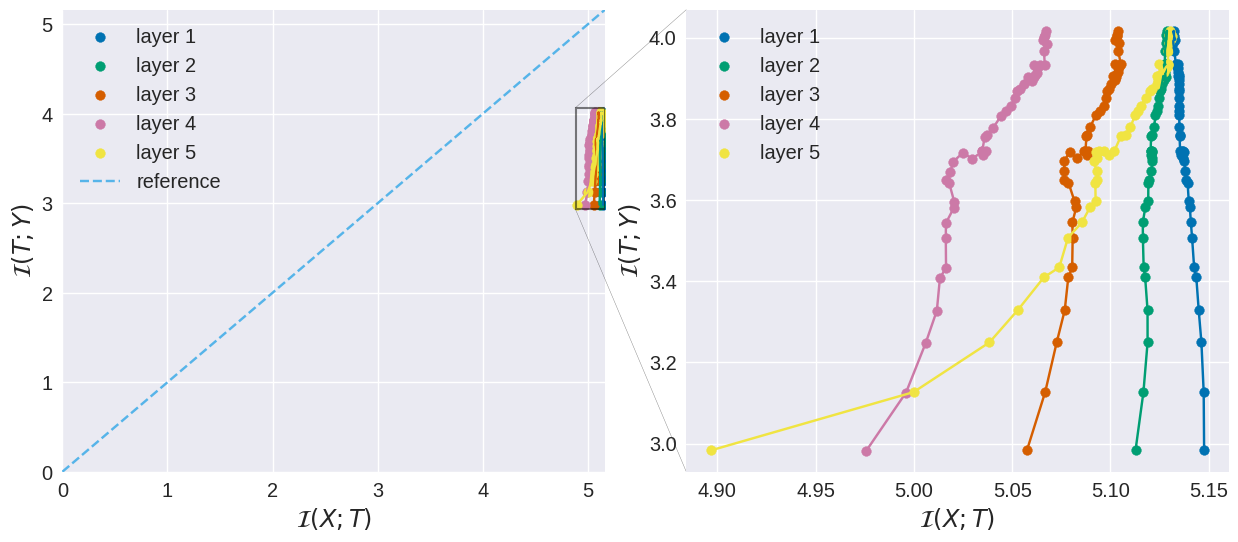

In [65]:
from IPDL import MatrixBasedRenyisEntropy

Ax = define_Ax(test_dataset[:], gamma=1e-2)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
    ax.set(xlim=(0, reference), ylim=(0, reference))
    axins = ax.inset_axes([1.15, 0., 1, 1])

    Ixt, Ity = ip.getMutualInformation(moving_average_n=5)

    for idx, current_Ixt in enumerate(Ixt):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        ax.plot(current_Ixt, current_Ity)

        axins.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        axins.plot(current_Ixt, current_Ity)

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')

axins.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
axins.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
axins.legend(fontsize='x-large')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', label='reference')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name,'CLHU_ip_end{}.pdf'.format(n_endmembers)), bbox_inches='tight')

In [61]:
# ip.to_df()
model.encoder[-1][-2].x

tensor([[-1.8666,  1.1205,  2.1018,  ...,  0.6423,  0.4397, -1.3094],
        [-2.0717,  1.2383,  2.5402,  ...,  0.5987,  0.3732, -1.5205],
        [-1.4641,  0.9655,  1.7394,  ...,  0.6181,  0.4511, -1.2839],
        ...,
        [ 1.0735,  0.7428, -0.9475,  ...,  0.8041, -2.5659, -0.8926],
        [ 2.3519,  1.1711, -1.1398,  ...,  1.2616, -2.8220, -1.2463],
        [ 1.2984,  0.6429, -0.9950,  ...,  0.7083, -2.5253, -0.7196]])

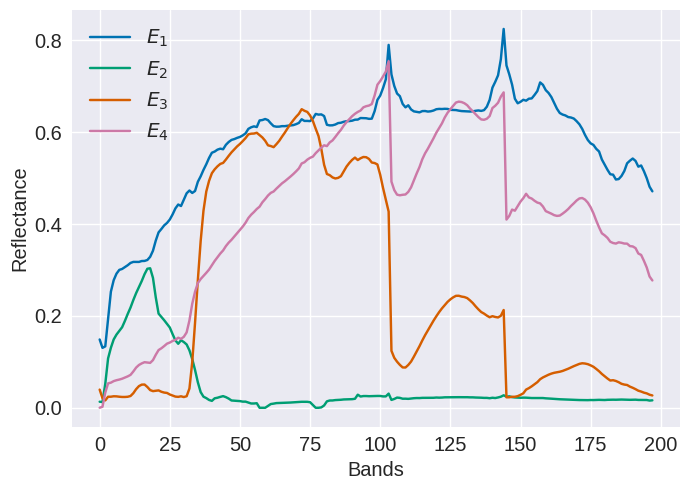

In [66]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
ebk = torch.sigmoid(model.ebk.detach()).cpu()

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(ebk.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
 
    plt.legend(fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

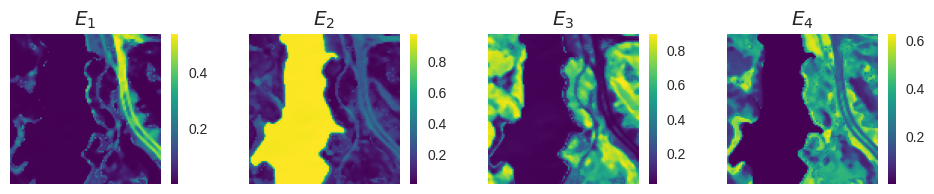

In [52]:
from torch.nn.functional import softmax
_ = model(dataset.X)

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(100, 100, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Testing

In [33]:
_ = model(test_dataset[:])

In [34]:
z_m = model.encoder[-1][-2].x.cpu()
model = model.cpu()
# z_m = model.encoder[-1][-2]

def similarity_loss(z_m, model, temperature=.5):

    X = model.projection(z_m)
    bs, n_bands = X.shape
    X = normalize(X, dim=1)

    normalize_ebk = normalize(model.ebk.detach(), dim=1).expand(bs, -1, -1)
    cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
    return (1 - torch.pow(cos, 2))/temperature

Abund = similarity_loss(z_m, model).detach()
AAbund = define_Ax(Abund, gamma=.01)

In [35]:
model.encoder[-1][-2].get_matrix().shape

torch.Size([128, 128])

In [36]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis
Hz = renyis.entropy(model.encoder[-1][-2].get_matrix())
Hz_p = renyis.entropy(model.projection[-1].get_matrix())
# HA = renyis.entropy(AAbund)


# Izy = renyis.mutualInformation(AAbund, model.encoder[-1][-2].get_matrix())
# print(Izy)

In [37]:
Ax = define_Ax(test_dataset[:], gamma=1e-2)
Az = model.encoder[-1][-2].get_matrix()

Ixz = renyis.mutualInformation(Ax, Az)
Ixz

Ixa = renyis.mutualInformation(Ax, AAbund)
print(Ixz, Ixa)

tensor(5.1161) tensor(5.0086)


In [38]:
Hx = renyis.entropy(Ax)
print(Hx)

Ha = renyis.entropy(AAbund)
print(Ha)

Hz = renyis.entropy(Az)
print(Hz)

tensor(5.1634)
tensor(6.0794)
tensor(6.3390)


In [40]:
MI = Hz - Ha
print(Hz, Ha, MI)

tensor(6.3390) tensor(6.0794) tensor(0.2596)


In [41]:
MI = Hz_p - Ha 
print(Hz_p, Ha, MI)

tensor(6.0979) tensor(6.0794) tensor(0.0184)


In [24]:
Az = model.encoder[-1][-2].get_matrix()
Abund = similarity_loss(z_m, model).detach()
AAbund = define_Ax(Abund, gamma=1e-2)

renyis.mutualInformation(Az, AAbund)

tensor(5.4584)

In [71]:
A2 = model.encoder[1][-3].get_matrix()

renyis.entropy(A2), renyis.mutualInformation(Az, A2)

(tensor(6.3367), tensor(5.9599))

In [73]:
renyis.entropy(AAbund), renyis.entropy(Az)

(tensor(4.4204), tensor(6.0272))